# Non-linear features & learning optimal portfolios
Given a set of stock characteristics, the problem of finding features (i.e. factors) that predict returns and optimizing a portfolio of those features in order to maximize out-of-sample performance can be expressed as a learning problem with neural network architectures. Gu et al (2018) apply neural network architectures to the task of predicting returns from stock characteristics, suggesting that non-linearities and interactions matter. However, portfolios are created downstream of their models' learning task in order to analyze the economic significance of the predictions. Brandt et al (2004) shows that directly estimating portfolio weights with stock characteristics outperforms benchmark portfolio optimization methods. However, they use linear models with a small number of pre-determined factors. This analysis aims to directly estimate portfolio weights as non-linear functions of arbitrary stock characteristics using neural network architectures trained at the portfolio optimization task.
## Background on portfolio optimization problem

The portfolio optimization problem is to find weights $w_{i,t}$ to maximize the expectation of some utility function of future portfolio returns $U(R_{t+1})$ where portfolio returns $R_{t+1} = \sum_i{w_{i,t}r_{i,t+1}}$. The weights can be parametrized as some function of the stock characteristics vector $w_{i,t} = f(x_{i,t})$, and the learning process is the find the arbitrary function $f$ that maximizes out-of-sample utility. 

In this analysis, I use the Sharpe ratio of long-short portfolio returns as my utility function and use neural network architectures to try to estimate the unknown function $f$. As a benchmark, I use a linear model, $f(x_{i,t})=p^Tx_{i,t}$ where $p$ is a parameter vector. Results are robust to using regularization in the benchmark model. 
## Motivating example
We can motivate the main analysis by looking at a very simple subset of stock characteristics: book equity to market equity (value) and market equity (size). These are the characteristics forming the Fama-French 3-Factor model. While this is a linear model of expected returns, Fama-French (1993) and other research shows that the relationship between these characteristics and returns is non-linear and dependent on interactions. In particular, they show that small growth stocks have particularly low expected returns and the relationship between value and growth is not as clear within the largest stocks. Below, we examine whether a very simple neural network can extract those non-linearities. Note that the functions used in this example will be discussed in more detail in the full analysis below.

In [2]:
from process_data import get_characteristics
from train_models import format_data_for_models, get_model_specs, train_and_save_model, loss_sharpe, evaluate_model_on_data
import os
import pickle
import pandas as pd
import numpy as np
np.random.seed(0)
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#be_me is book equity to market equity (Fama-French value) and mve is market equity (Fama-French size) 
df = get_characteristics()[['be_me','mve']].dropna()
#split into only a train/test set
data = format_data_for_models(df,split_train=.7,split_val=1)
data['X_train'].shape,data['X_val'].shape,data['X_test'].shape

((1197000, 2), (0, 2), (516000, 2))

Below we train a linear model of these two characteristics to maximize the Sharpe ratio of a long-short portfolio.

In [10]:
model_linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1,activation='linear',input_shape=data['X_train'][0].shape),
    ])

optimizer = tf.keras.optimizers.Adam(.1)
model_linear.compile(
    loss=loss_sharpe,
    optimizer = optimizer,
    )
print(model_linear.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
history = model_linear.fit(data['X_train'],data['Y_train'],shuffle=False,batch_size=3000*120,epochs=50)

Epoch 1/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: 0.0908
Epoch 2/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: 0.0760
Epoch 3/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: 0.0582
Epoch 4/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: 0.0313
Epoch 5/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.0084
Epoch 6/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.0540
Epoch 7/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.0865
Epoch 8/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1031
Epoch 9/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1096
Epoch 10/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1111
Epoch 11/50
1197000/1197000 [==============================] - 0s 0us/sample - loss

Below we train a very simple neural network with just one hidden layer of 2 units. This network will be able to fit very simple non-linearities and interactions between the two inputs.

In [38]:
model_nonlinear = tf.keras.Sequential([
    tf.keras.layers.Dense(2,activation='sigmoid',input_shape=data['X_train'][0].shape,name='hidden'),
    tf.keras.layers.Dense(1,activation='sigmoid',name='output_nonlinear'),
    ])

optimizer = tf.keras.optimizers.Adam(.1)
model_nonlinear.compile(
    loss=loss_sharpe,
    optimizer = optimizer,
    )
print(model_nonlinear.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 2)                 6         
_________________________________________________________________
output_nonlinear (Dense)     (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = model_nonlinear.fit(data['X_train'],data['Y_train'],shuffle=False,batch_size=3000*120,epochs=50)

Epoch 1/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1079
Epoch 2/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1388
Epoch 3/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1944
Epoch 4/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2156
Epoch 5/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.1892
Epoch 6/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2112
Epoch 7/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2165
Epoch 8/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2033
Epoch 9/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2049
Epoch 10/50
1197000/1197000 [==============================] - 0s 0us/sample - loss: -0.2035
Epoch 11/50
1197000/1197000 [==============================] - 0s 0us/sample - 

In [40]:
#use models to predict
df['pred_linear'] = model_linear.predict(df[['be_me','mve']])
df['pred_nonlinear'] = model_nonlinear.predict(df[['be_me','mve']])
#transform predictions into portfolio weights
df[['pred_linear','pred_nonlinear']] = df.groupby('date')[['pred_linear','pred_nonlinear']].transform(lambda x: 2*(x.rank()-x.rank().mean())/(x.rank()-x.rank().mean()).abs().sum())
#get value and size quintiles
df[['value_quintile','size_quintile']] = df[['be_me','mve']].apply(lambda x: pd.qcut(x,5,labels=False,retbins=False,duplicates='drop'))

Below, we can see that the linear model (left plot) tends to load on value stocks (high book equity to market equity) and small stocks (low market equity) in the lower left corner of the left heatmap (and vice-versa for large growth stocks). However, the non-linear model finds a more complicated relationship. In particular, small growth stocks are shorted the most, while the relationship between value and growth within the largest stocks is less clear (consistent with Fama-French's original research). 

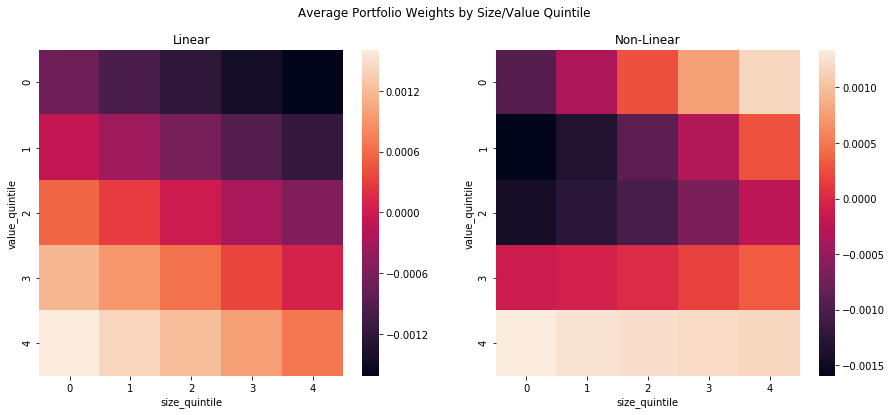

In [67]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize = (15,6)) # width x height
fig.suptitle("Average Portfolio Weights by Size/Value Quintile")
ax1.set_title('Linear')
ax2.set_title('Non-Linear')
sns.heatmap(df.groupby(['value_quintile','size_quintile'])['pred_linear'].mean().unstack(),ax=ax1)
sns.heatmap(df.groupby(['value_quintile','size_quintile'])['pred_nonlinear'].mean().unstack(),ax=ax2)
plt.show()

Furthermore, if we plot cumulative returns from portfolios generated from the models, the non-linear model outperforms the linear value/size model out of sample. Note that the linear model's poor performance is consistent with size and value in the recent period.

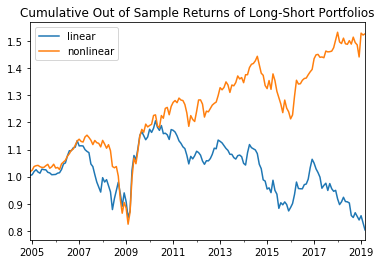

In [68]:
#get out of sample returns
ret_linear_test,_ = evaluate_model_on_data(model_linear,data['X_test'],data['Y_test'],data['D_test'])
ret_nonlinear_test,_ = evaluate_model_on_data(model_nonlinear,data['X_test'],data['Y_test'],data['D_test'])
ret = pd.concat([ret_linear_test,ret_nonlinear_test],1)
ret.columns = ['linear','nonlinear']
(1+ret).cumprod().plot()
plt.title('Cumulative Out of Sample Returns of Long-Short Portfolios')
plt.show()

## Main analysis

With this motivating example in mind, we turn to the main analysis using the complete set of stock characteristics.
## Summary of data processing steps

The get_characteristics function in process_data.py downloads data from WRDS (CRSP, Compustat, IBES, etc.), calculates commonly used stock characteristics, and normalizes the resulting dataframe. 

The characteristics data contains 1,980,679 firm-month observations from January 1960 through March 2019. Each observation is a vector of 280 commonly used characteristics (i.e. technical indicators, valuation ratios, quality measures, analyst estimates). For each characteristic there is a raw and industry-adjusted version, and many characteristics are highly correlated (for example, valuation ratios with slightly different accounting definitions, and versions of fundamental characteristics that are forward-filled for up to 12-months). 

In [8]:
df = get_characteristics()
df.shape

(1980679, 280)

In [9]:
df.head()

,,mean_5,mean_10,mean_22,mean_198,mean_252,mean_756,std_22,std_252,volume_5,volume_5_shrout,...,surprise_z_ia,chanalyst_ia,pchanalyst_ia,pe0_ia,pe1_ia,pe2_ia,pe3_ia,pe4_ia,pe5_ia,ltg_ia
permno,date,,,,,,,,,,,,,,,,,,,,,
10006.0,1960-01-01,-0.896284,-0.260869,-0.318628,NaN,NaN,NaN,-0.254434,NaN,-0.414886,-0.254666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014.0,1960-01-01,-1.343426,-0.464544,-1.095499,-0.815115,0.428516,1.198570,0.877674,2.571398,-0.123750,0.098251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10022.0,1960-01-01,1.403910,1.489811,0.567477,0.560376,1.043213,1.377155,1.225888,0.793453,0.530111,1.383547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10030.0,1960-01-01,-0.326136,-1.502992,-0.086946,0.139154,0.096745,-0.320082,0.339977,-0.679396,-0.481704,-0.406583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057.0,1960-01-01,-0.057002,-0.150390,0.832078,-0.213636,-0.125684,-1.284502,-0.707516,-0.485068,-0.553294,-0.350006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


train_models.py has functions to partition the data for training, validation, and testing, create models for various hyperparameter specifications, and save models after training. Results from the data processing step is shown below.

The data is partitioned into train, validation, and test sets. For this analysis I hold out the last 30% of months for testing, and randomly select 40% of the remaining months for validation. The other important step is padding each month with zeros to have exactly n_stocks of observations (in this case 3000). This is because the loss_sharpe loss function reshapes the data to calculate long-short portfolio returns. 

In [53]:
data = format_data_for_models(df)
data['X_train'].shape,data['X_val'].shape,data['X_test'].shape

((894000, 280), (597000, 280), (642000, 280))

## Results

Hyperparameter specifications are generated (get_model_specs) and models/results are saved based on those specifications (train_and_save_model). This analysis only considers a limited range of hyperparameters, and some are chosen by trial and error (see get_model_specs in train_models.py); results could be improved by doing a more thorough search. Here, the main hyperparameters are number of layers (n_layers=1,2,3), number of units in each layer (n_units=16,32,64), and amount of dropout (dropout=.25,.5,.75). 

Selected below are the 5 models that perform best in the validation set (based on Sharpe ratio of dollar-neutral long-short portfolios with leverage of 1). The simpler models (fewer layers and units) with more regularization tend to perform better out-of-sample. This isn't surprising given the low signal-to-noise issue with return data. More work could be done to try to deal with this issue (i.e. more/different types of regularization, different loss functions such as converting returns to ranks, etc).    

In [24]:
specs = get_model_specs()
##train and save models from specifications 
#for i,spec in model_specs.items():
#    train_and_save_model(data,i,**spec)
#    K.clear_session()
with open('models/model_returns.p','rb') as f:
    model_returns = pickle.load(f)
with open('models/model_weights.p','rb') as f:
    model_weights = pickle.load(f)
#calculate Sharpe ratio on train, validation, and test sets
for mod,mod_dict in model_returns.items():
    for datatype,ret in mod_dict.items():
        specs[mod][datatype+'_sharpe'] = np.mean(ret)/np.std(ret)
model_summary = pd.DataFrame(specs).T
top_5_models = list(model_summary.loc[model_summary.linear==False].sort_values(by=['val_sharpe'])[-5:].index)
model_summary.loc[top_5_models]

,linear,lr,n_layers,n_units,dropout,train_sharpe,val_sharpe,test_sharpe,l1_penalty
7,False,0.01,1,64,0.75,1.99475,1.3809,0.652103,NaN
1,False,0.01,1,16,0.75,2.22569,1.40807,0.565593,NaN
12,False,0.01,2,32,0.5,2.25913,1.42017,0.640601,NaN
10,False,0.01,2,16,0.75,2.16908,1.43078,0.540291,NaN
4,False,0.01,1,32,0.75,2.35029,1.44979,0.562796,NaN


Selected below is the benchmark linear model. Note that the selected non-linear models perform between 18% and 42% better than the benchmark based on out-of-sample Sharpe ratio.

In [32]:
benchmark_model = list(model_summary.loc[model_summary.linear==True].sort_values(by=['val_sharpe']).loc[-1:].index)
model_summary.loc[benchmark_model]

,linear,lr,n_layers,n_units,dropout,train_sharpe,val_sharpe,test_sharpe,l1_penalty
27,True,0.0120306,NaN,NaN,NaN,1.93713,1.15212,0.458745,0


Here we can visualize the performance of the non-linear models compared to the benchmark in the out-of-sample (test) period by plotting the cumulative long-short portfolio returns. Each of the models outperforms the benchmark, however, they are highly correlated indicates that there isn't a huge benefit to diversifying across models. There could be ways of adjusting the loss function to try to explicitly find diversifying strategies.

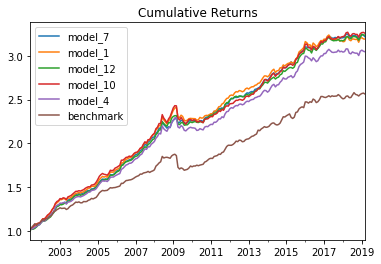

In [56]:
selected_returns = pd.concat([model_returns[i]['test'] for i in top_5_models+benchmark_model],1)
selected_returns.columns = ['model_'+str(i) for i in top_5_models]+['benchmark']
(1+selected_returns).cumprod().plot()
plt.title('Cumulative Returns')
plt.show()

The code below calculates the average (linear) loadings on each characteristic using an example model (model 12, the third best performing on the validation set). We can see that the model negatively loads on short term reversal signals (5- and 10- day industry adjusted stock returns) and signals related to increases in debt. The model positively loads on a number of cash-flow based metrics (value, quality, momentum). 

In [44]:
model = tf.keras.models.load_model('models/model_12.h5',custom_objects={'loss_sharpe':loss_sharpe})
loadings_stock = model.predict(df.fillna(0).values)
loadings_char = df.multiply(loadings_stock,0)
loadings_char = loadings_char.groupby('date')[df.columns].sum()
loadings_char.mean().sort_values()

mean_10_ia             -220.555432
mean_5_ia              -217.243272
chdebt_asset_asof_ia   -203.671799
td_d_ev_ia             -199.402682
chdebt_asset_asof      -182.092492
                           ...    
cf_me_ia                270.395021
cf_asset_asof_ia        308.727684
cf_ev_ia                330.009003
cf_momentum_asof        346.267143
cf_momentum_asof_ia     357.936269
Length: 280, dtype: float64

Below visualizes how well this specific model ranks stocks, by sorting into quintiles and plotting equal-weighted quintile portfolio returns over the test period. 

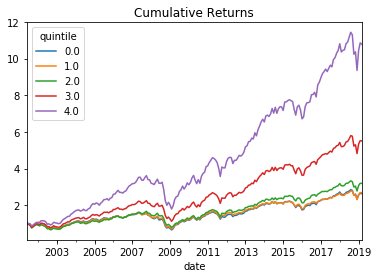

In [57]:
from process_data import get_crsp_m
from pandas.tseries.offsets import *
ranks = pd.DataFrame(loadings_stock,index=df.index,columns=['rank']).reset_index()
crsp = get_crsp_m()
crsp['date'] = pd.to_datetime(crsp['date'])-MonthBegin(1)
ranks = ranks.reset_index().merge(crsp[['permno','date','retadj']],how='left',on=['permno','date'])
ranks['quintile'] = ranks.groupby('date')['rank'].transform(lambda x: pd.qcut(x,5,labels=False,retbins=False,duplicates='drop'))
rets = ranks.groupby(['date','quintile'])['retadj'].mean().unstack()
rets = rets.loc[data['D_test']]
(1+rets).cumprod().plot()
plt.title('Cumulative Returns')
plt.show()

## Next steps

1. Broaden hyperparameter search
2. Try different types of regularization or different learning objectives aimes at low-signal to noise problem
3. Penalize strategies that are correlated with linear strategies, if goal is finding non-linear features
4. Re-train model over time (i.e. with an expanding window); examine extent to which parameters change over tiem and methods for finding stable parameters